In [1]:
from __future__ import print_function, division

import argparse
import logging
import numpy as np
import cv2
import os
from pathlib import Path
from tqdm import tqdm

from lib.human_loader import StereoHumanDataset
from lib.network import RtStereoHumanModel
from config.stereo_human_config import ConfigStereoHuman as config
from lib.utils import get_novel_calib
from lib.GaussianRender import pts2render

import torch
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
class StereoHumanRender:
    def __init__(self, cfg_file, phase):
        self.cfg = cfg_file
        self.bs = self.cfg.batch_size

        self.model = RtStereoHumanModel(self.cfg, with_gs_render=True)
        self.dataset = StereoHumanDataset(self.cfg.dataset, phase=phase)
        self.model.cuda()
        if self.cfg.restore_ckpt:
            self.load_ckpt(self.cfg.restore_ckpt)
        self.model.eval()

    def infer_static(self, view_select, novel_view_nums):
        total_samples = len(os.listdir(os.path.join(self.cfg.dataset.test_data_root, 'img')))
        for idx in tqdm(range(total_samples)):
            item = self.dataset.get_test_item(idx, source_id=view_select)
            data = self.fetch_data(item)
            for i in range(novel_view_nums):
                ratio_tmp = (i+0.5)*(1/novel_view_nums)
                data_i = get_novel_calib(data, self.cfg.dataset, ratio=ratio_tmp, intr_key='intr_ori', extr_key='extr_ori')
                with torch.no_grad():
                    data_i, _, _ = self.model(data_i, is_train=False)
                    data_i = pts2render(data_i, bg_color=self.cfg.dataset.bg_color)

                render_novel = self.tensor2np(data['novel_view']['img_pred'])
                cv2.imwrite(self.cfg.test_out_path + '/%s_novel%s.jpg' % (data_i['name'], str(i).zfill(2)), render_novel)

    def tensor2np(self, img_tensor):
        img_np = img_tensor.permute(0, 2, 3, 1)[0].detach().cpu().numpy()
        img_np = img_np * 255
        img_np = img_np[:, :, ::-1].astype(np.uint8)
        return img_np

    def fetch_data(self, data):
        for view in ['lmain', 'rmain']:
            for item in data[view].keys():
                data[view][item] = data[view][item].cuda().unsqueeze(0)
        return data

    def load_ckpt(self, load_path):
        assert os.path.exists(load_path)
        logging.info(f"Loading checkpoint from {load_path} ...")
        ckpt = torch.load(load_path, map_location='cuda', weights_only=False)
        self.model.load_state_dict(ckpt['network'], strict=True)
        logging.info(f"Parameter loading done")

In [8]:
import sys

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')
sys.argv = ['script_name', '--test_data_root', 'real_data//GPS', '--ckpt_path', 'pretrained/GPS-GS_stage2_final.pth']

parser = argparse.ArgumentParser()
parser.add_argument('--test_data_root', type=str, required=True)
parser.add_argument('--ckpt_path', type=str, required=True)
parser.add_argument('--novel_view_nums', type=int, default=5)

arg = parser.parse_args()

cfg = config()
cfg_for_train = os.path.join('./config', 'stage2.yaml')
cfg.load(cfg_for_train)
cfg = cfg.get_cfg()   
cfg.defrost()
cfg.batch_size = 1
cfg.dataset.test_data_root = arg.test_data_root
cfg.dataset.use_processed_data = False
cfg.restore_ckpt = arg.ckpt_path
cfg.test_out_path = './interp_out'
Path(cfg.test_out_path).mkdir(exist_ok=True, parents=True)
cfg.freeze()
"""# Access the arguments
test_data_root = arg.test_data_root
ckpt_path = arg.ckpt_path

# Print the arguments to verify
print(f"Test Data Root: {test_data_root}")
print(f"Checkpoint Path: {ckpt_path}")"""

'# Access the arguments\ntest_data_root = arg.test_data_root\nckpt_path = arg.ckpt_path\n\n# Print the arguments to verify\nprint(f"Test Data Root: {test_data_root}")\nprint(f"Checkpoint Path: {ckpt_path}")'

In [9]:
cfg.dataset.use_processed_data

False

In [10]:
render = StereoHumanRender(cfg, phase='test')

2026-01-26 14:35:35,151 INFO     [2729239678.py:42] Loading checkpoint from pretrained/GPS-GS_stage2_final.pth ...
2026-01-26 14:35:35,454 INFO     [2729239678.py:45] Parameter loading done


In [11]:
total_samples = len(os.listdir(os.path.join(render.cfg.dataset.test_data_root, 'img'))) #getting all the subfolders each containing all views at one moment in time

In [12]:
item = render.dataset.get_test_item(0, source_id=[0,1]) #containing images (-1,1), masks and cam parameters

In [13]:
item['rmain']['intr_ori']

tensor([[860.1793,   0.0000, 514.4534],
        [  0.0000, 860.3584, 555.1299],
        [  0.0000,   0.0000,   1.0000]])

In [14]:
np.histogram(item['rmain']['img'].cpu().numpy()) #getting the shape of the image

(array([   9485,   28501,   54621,   48043, 2785456,   33545,   23158,
          69911,   73998,   19010]),
 array([-0.79607844, -0.6164706 , -0.43686277, -0.25725496, -0.07764709,
         0.10196078,  0.28156853,  0.4611764 ,  0.64078426,  0.82039213,
         1.        ], dtype=float32))

2026-01-26 14:36:24,618 WARNING  [image.py:661] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..1.0].
2026-01-26 14:36:24,642 WARNING  [image.py:661] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..1.0].


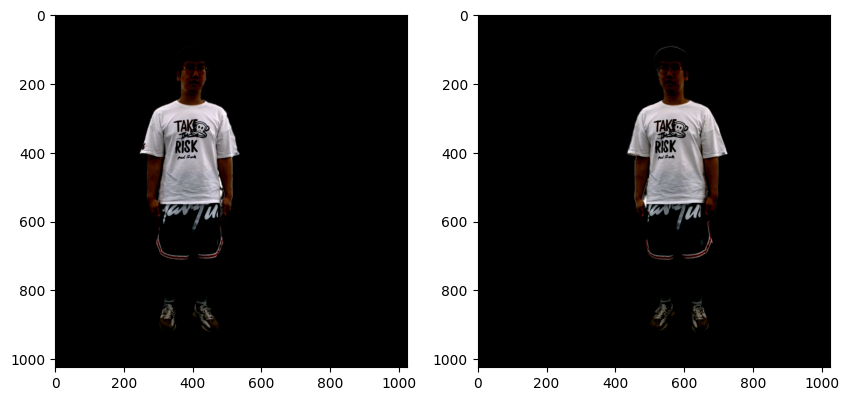

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(item['lmain']['img'].permute(1,2,0).cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(item['rmain']['img'].permute(1,2,0).cpu().numpy())

In [17]:
print(item['lmain']['extr'])
print(item['rmain']['extr'])
print(item['lmain']['extr_ori']) #result shows that the left camera's y location is higher therefore y is pointing upward
print(item['rmain']['extr_ori'])

tensor([[ 0.5433, -0.0097,  0.8395,  0.3635],
        [-0.1004, -0.9935,  0.0536,  0.8249],
        [ 0.8335, -0.1134, -0.5408,  1.9049]])
tensor([[ 0.5433, -0.0097,  0.8395, -0.3403],
        [-0.1004, -0.9935,  0.0536,  0.8249],
        [ 0.8335, -0.1134, -0.5408,  1.9049]])
tensor([[ 0.3477,  0.0269,  0.9372, -0.0740],
        [-0.0925, -0.9937,  0.0628,  0.8322],
        [ 0.9330, -0.1086, -0.3431,  1.9347]])
tensor([[ 0.6937,  0.0035,  0.7203, -0.0039],
        [-0.0809, -0.9933,  0.0827,  0.8132],
        [ 0.7157, -0.1157, -0.6887,  1.9400]])


# Now Explore the render data

In [ ]:
# Let's first visualize the mask, depth, and image together to understand the data
import matplotlib.pyplot as plt

# Set base path
base_path = os.path.join('render_data', 'render_data', 'train', 'parm')
if not os.path.exists(base_path):
    base_path = r'd:\GitHub\GPS-Gaussian\render_data\render_data\train\parm'

train_root = os.path.dirname(base_path)
view_name = '0004_000'

img_path = os.path.join(train_root, 'img', view_name, '0.jpg')
mask_path = os.path.join(train_root, 'mask', view_name, '0.png')
depth_path = os.path.join(train_root, 'depth', view_name, '0.png')

# Load data
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
if len(mask.shape) > 2:
    mask = mask[:, :, 0]

depth_raw = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
inv_depth = depth_raw / (2.0 ** 15)

# Analyze mask
print("=== Mask Analysis ===")
print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")
print(f"Mask unique values: {np.unique(mask)}")
print(f"Mask range: [{mask.min()}, {mask.max()}]")
print(f"Number of masked pixels (>128): {np.sum(mask > 128)}")
print(f"Percentage masked: {100 * np.sum(mask > 128) / mask.size:.2f}%")

# Analyze inverse depth
print(f"\n=== Inverse Depth Analysis (all pixels) ===")
print(f"Inv depth shape: {inv_depth.shape}, dtype: {inv_depth.dtype}")
print(f"Inv depth range: [{inv_depth.min():.6f}, {inv_depth.max():.6f}]")
print(f"Non-zero inv depth pixels: {np.sum(inv_depth > 0)}")

# Analyze inverse depth within mask
masked_inv_depth = inv_depth[mask > 128]
print(f"\n=== Inverse Depth Analysis (masked pixels only) ===")
print(f"Masked inv depth range: [{masked_inv_depth.min():.6f}, {masked_inv_depth.max():.6f}]")
print(f"Masked inv depth mean: {masked_inv_depth.mean():.6f}")
print(f"Masked inv depth median: {np.median(masked_inv_depth):.6f}")

# Convert to actual depth for masked pixels
masked_depth = 1.0 / (masked_inv_depth + 1e-8)
masked_depth = masked_depth[masked_depth < 100]  # Filter out extreme values
print(f"\n=== Actual Depth (masked, filtered) ===")
print(f"Depth range: [{masked_depth.min():.3f}, {masked_depth.max():.3f}] meters")
print(f"Depth mean: {masked_depth.mean():.3f} meters")
print(f"Depth median: {np.median(masked_depth):.3f} meters")

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img)
axes[0, 0].set_title('RGB Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(mask, cmap='gray')
axes[0, 1].set_title(f'Mask ({np.sum(mask > 128)} pixels)')
axes[0, 1].axis('off')

axes[0, 2].imshow(img * (mask[:, :, np.newaxis] > 128))
axes[0, 2].set_title('Masked Image')
axes[0, 2].axis('off')

axes[1, 0].imshow(inv_depth, cmap='viridis')
axes[1, 0].set_title('Inverse Depth (all)')
axes[1, 0].axis('off')

masked_inv_depth_vis = np.zeros_like(inv_depth)
masked_inv_depth_vis[mask > 128] = inv_depth[mask > 128]
axes[1, 1].imshow(masked_inv_depth_vis, cmap='viridis')
axes[1, 1].set_title('Inverse Depth (masked)')
axes[1, 1].axis('off')

# Depth visualization (clipped for visibility)
depth_vis = 1.0 / (inv_depth + 1e-8)
depth_vis = np.clip(depth_vis, 0, 10)  # Clip to 10m for visualization
depth_vis[mask <= 128] = 0
axes[1, 2].imshow(depth_vis, cmap='plasma')
axes[1, 2].set_title('Depth (masked, 0-10m)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [25]:
import cv2
import open3d as o3d

# First, let's check a depth map to verify if it's inverse depth or regular depth
def read_depth(name):
    # Based on lib/human_loader.py: returns inverse depth (1/Z)
    return cv2.imread(name, cv2.IMREAD_UNCHANGED).astype(np.float32) / 2.0 ** 15

def depth2pts_np(inv_depth_map, extrinsic, intrinsic, mask=None):
    """
    Convert inverse depth map to 3D points in world coordinates
    
    Args:
        inv_depth_map: HxW inverse depth map (1/Z format)
        extrinsic: 3x4 or 4x4 [R|t] matrix (World -> Camera transformation)
        intrinsic: 3x3 camera intrinsic matrix
        mask: Optional binary mask to filter valid pixels
    
    Returns:
        pts_world: (N, 3) array of 3D points in world coordinates
        Z_vals: (N,) array of depth values
    """
    H, W = inv_depth_map.shape
    
    # Create pixel coordinate grid
    u, v = np.meshgrid(np.arange(W), np.arange(H))
    
    # Filter by mask first if provided
    if mask is not None:
        valid_mask = mask > 128
        # Also filter out very small inverse depth (far away / invalid)
        valid_mask &= (inv_depth_map > 0.05)  # Corresponds to depth < 20m
    else:
        valid_mask = inv_depth_map > 0.05
    
    # Apply mask to get valid pixels
    u_valid = u[valid_mask]
    v_valid = v[valid_mask]
    inv_depth_valid = inv_depth_map[valid_mask]
    
    # Convert inverse depth to depth
    Z = 1.0 / (inv_depth_valid + 1e-8)
    
    # Print depth range statistics
    print(f"\n=== Depth Range Statistics (masked pixels only) ===")
    print(f"Valid pixels: {len(Z)} out of {H*W}")
    print(f"Inverse depth - Min: {inv_depth_valid.min():.6f}, Max: {inv_depth_valid.max():.6f}, Mean: {inv_depth_valid.mean():.6f}")
    print(f"Depth (Z) - Min: {Z.min():.3f}, Max: {Z.max():.3f}, Mean: {Z.mean():.3f}, Median: {np.median(Z):.3f}")
    print(f"Depth percentiles:")
    for p in [10, 25, 50, 75, 90, 95, 99]:
        print(f"  {p}%: {np.percentile(Z, p):.3f}")
    
    # Extract intrinsic parameters
    fx = intrinsic[0, 0]
    fy = intrinsic[1, 1]
    cx = intrinsic[0, 2]
    cy = intrinsic[1, 2]
    
    # Unproject pixels to 3D camera coordinates
    X_cam = (u_valid - cx) * Z / fx
    Y_cam = (v_valid - cy) * Z / fy
    
    # Stack into camera coordinate points (N, 3)
    P_cam = np.vstack((X_cam, Y_cam, Z))  # (3, N)
    
    # Transform from camera coordinates to world coordinates
    # Camera to world: P_world = R^T * (P_cam - t)
    # Where [R|t] is the world-to-camera extrinsic matrix
    R = extrinsic[:3, :3]
    t = extrinsic[:3, 3].reshape(3, 1)
    
    P_world = np.dot(R.T, (P_cam - t))  # (3, N)
    
    return P_world.T, Z  # Return (N, 3) and (N,)


# Setup paths
train_root = os.path.dirname(base_path)  # base_path points to parm folder
view_name = '0004_000'

img_path = os.path.join(train_root, 'img', view_name, '0.jpg')
mask_path = os.path.join(train_root, 'mask', view_name, '0.png')
depth_path = os.path.join(train_root, 'depth', view_name, '0.png')
ext_path = os.path.join(train_root, 'parm', view_name, '0_extrinsic.npy')
int_path = os.path.join(train_root, 'parm', view_name, '0_intrinsic.npy')

if os.path.exists(img_path) and os.path.exists(depth_path):
    print(f"Loading data from {view_name}...")
    
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if len(mask.shape) > 2:
        mask = mask[:, :, 0]
    
    # Load inverse depth
    inv_depth = read_depth(depth_path)
    
    # Load camera parameters (OpenCV format)
    extrinsic = np.load(ext_path)
    intrinsic = np.load(int_path)
    
    print(f"\n=== Data Shapes ===")
    print(f"Image shape: {img.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Inverse depth shape: {inv_depth.shape}")
    print(f"\n=== Inverse Depth (raw) Statistics ===")
    print(f"Min={inv_depth.min():.6f}, Max={inv_depth.max():.6f}, Mean={inv_depth.mean():.6f}")
    print(f"\n=== Camera Parameters ===")
    print(f"Extrinsic matrix shape: {extrinsic.shape}")
    print(f"Intrinsic matrix:\n{intrinsic}")
    
    # Generate 3D point cloud with proper masking
    pts_world, Z_vals = depth2pts_np(inv_depth, extrinsic, intrinsic, mask=mask)
    
    # Get colors for valid points
    # Create a flat index for valid pixels
    H, W = inv_depth.shape
    u, v = np.meshgrid(np.arange(W), np.arange(H))
    valid_mask = (mask > 128) & (inv_depth > 0.05)
    valid_colors = img[valid_mask]
    
    print(f"\n=== Point Cloud Info ===")
    print(f"Generated {len(pts_world)} valid points")
    print(f"Point cloud bounds (world coordinates):")
    print(f"  X: [{pts_world[:,0].min():.3f}, {pts_world[:,0].max():.3f}]")
    print(f"  Y: [{pts_world[:,1].min():.3f}, {pts_world[:,1].max():.3f}]")
    print(f"  Z: [{pts_world[:,2].min():.3f}, {pts_world[:,2].max():.3f}]")
    
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts_world)
    pcd.colors = o3d.utility.Vector3dVector(valid_colors / 255.0)
    
    # Save to PLY file
    ply_out = 'point_cloud_0004_000_view0.ply'
    o3d.io.write_point_cloud(ply_out, pcd)
    print(f"\nSaved point cloud to {ply_out}")
    
    # Visualize with Open3D
    print("\nOpening Open3D visualizer...")
    print("Controls: Mouse to rotate, scroll to zoom, Ctrl+C in terminal to close")
    o3d.visualization.draw_geometries([pcd], 
                                      window_name=f"Point Cloud: {view_name}",
                                      width=1024, 
                                      height=768)
    
else:
    print(f"Files not found.")
    print(f"Checked paths:")
    print(f"  Image: {img_path}")
    print(f"  Depth: {depth_path}")

Loading data from 0004_000...

=== Data Shapes ===
Image shape: (1024, 1024, 3)
Mask shape: (1024, 1024)
Inverse depth shape: (1024, 1024)

=== Inverse Depth (raw) Statistics ===
Min=0.000000, Max=0.551880, Mean=0.053515

=== Camera Parameters ===
Extrinsic matrix shape: (3, 4)
Intrinsic matrix:
[[819.2   0.  512. ]
 [  0.  819.2 537. ]
 [  0.    0.    1. ]]

=== Depth Range Statistics (masked pixels only) ===
Valid pixels: 110499 out of 1048576
Inverse depth - Min: 0.443726, Max: 0.551880, Mean: 0.507833
Depth (Z) - Min: 1.812, Max: 2.254, Mean: 1.972, Median: 1.960
Depth percentiles:
  10%: 1.894
  25%: 1.916
  50%: 1.960
  75%: 2.020
  90%: 2.075
  95%: 2.110
  99%: 2.167

=== Point Cloud Info ===
Generated 110499 valid points
Point cloud bounds (world coordinates):
  X: [-0.368, 0.381]
  Y: [0.000, 1.787]
  Z: [-0.180, 0.260]

Saved point cloud to point_cloud_0004_000_view0.ply

Opening Open3D visualizer...
Controls: Mouse to rotate, scroll to zoom, Ctrl+C in terminal to close


In [20]:
import numpy as np
import os
import math

def get_camera_center(extrinsic):
    # extrinsic is 4x4 assuming [R|t]
    if extrinsic.shape == (3, 4):
        extrinsic = np.vstack([extrinsic, [0, 0, 0, 1]])
    
    R = extrinsic[:3, :3]
    t = extrinsic[:3, 3]
    C = -np.dot(R.T, t)
    return C

def get_rotation_angle(R1, R2):
    R_diff = np.dot(R1, R2.T)
    val = (np.trace(R_diff) - 1) / 2
    val = np.clip(val, -1.0, 1.0)
    return math.acos(val) * 180.0 / math.pi

# Adjust this path if necessary relative to where the notebook is running
base_path = os.path.join('render_data', 'render_data', 'train', 'parm')
# Using absolute path from context if relative fails to verify
if not os.path.exists(base_path):
    base_path = r'd:\GitHub\GPS-Gaussian\render_data\render_data\train\parm'

targets = ['0004_000', '0005_000', '0006_000']

for target in targets:
    folder_path = os.path.join(base_path, target)
    if not os.path.exists(folder_path):
        print(f"Folder {target} does not exist.")
        continue
    
    file_0 = os.path.join(folder_path, '0_extrinsic.npy')
    file_1 = os.path.join(folder_path, '1_extrinsic.npy')

    if not os.path.exists(file_0) or not os.path.exists(file_1):
        print(f"Files missing in {target}")
        continue

    ext0 = np.load(file_0)
    ext1 = np.load(file_1)

    C0 = get_camera_center(ext0)
    C1 = get_camera_center(ext1)

    dist = np.linalg.norm(C0 - C1)

    R0 = ext0[:3, :3]
    R1 = ext1[:3, :3]

    angle = get_rotation_angle(R0, R1)

    print(f"--- {target} ---")
    print(f"Distance between camera 0 and 1: {dist:.6f}")
    print(f"Orientation difference (degrees): {angle:.6f}")

--- 0004_000 ---
Distance between camera 0 and 1: 0.788222
Orientation difference (degrees): 22.500000
--- 0005_000 ---
Distance between camera 0 and 1: 0.788222
Orientation difference (degrees): 22.500000
Folder 0006_000 does not exist.


# Explore training code to start fine tuning Unimatch, possibly starting with generator

In [21]:
from torch.cuda.amp import autocast as autocast

image = torch.cat([lmaintensor, lmaintensor], dim=0)


with autocast(enabled=render.model.cfg.raft.mixed_precision):
    img_feat = render.model.img_encoder(image)

In [22]:
flow_up = render.model.raft_stereo(img_feat[2], iters=render.model.val_iters, test_mode=True)

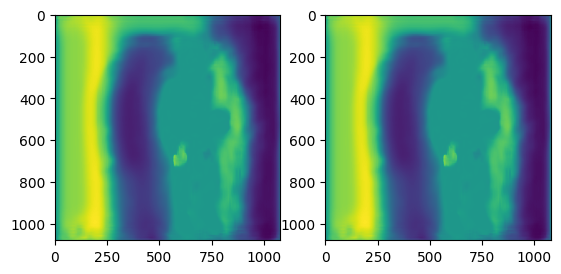

In [23]:
plt.subplot(1,2,1)
plt.imshow(flow_up[0][0].detach().cpu().numpy().squeeze())
plt.subplot(1,2,2)
plt.imshow(flow_up[1][0].detach().cpu().numpy().squeeze())

## Saved item contain rectified images, cam matrix after rectification and the original cam matrix

2025-04-14-16-03-48_E3734F4C-087F-44E8-A6E1-4E1FE050BAE7_masked_0
2025-04-14-16-03-48_E20713D5-D0E6-48AE-A72C-0A0B15E341A4_masked_0


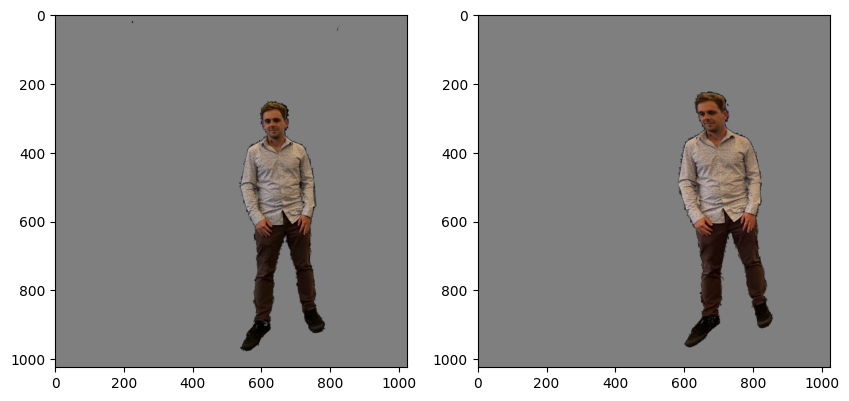

In [31]:
item = render.dataset.get_test_item(0, source_id=[11,10]) #containing images (-1,1), masks and cam parameters
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(item['lmain']['img'].permute(1,2,0).cpu().numpy()*0.5 + 0.5)
plt.subplot(1,2,2)
plt.imshow(item['rmain']['img'].permute(1,2,0).cpu().numpy()*0.5 + 0.5)

In [18]:
print(item['lmain']['extr'])
print(item['rmain']['extr'])
print(item['lmain']['extr_ori'])
print(item['rmain']['extr_ori'])

tensor([[ 0.8878,  0.1014,  0.4490,  0.4941],
        [-0.0879,  0.9948, -0.0509,  1.0178],
        [-0.4519,  0.0057,  0.8921,  0.6017]])
tensor([[ 0.8878,  0.1014,  0.4490,  0.8229],
        [-0.0879,  0.9948, -0.0509,  1.0178],
        [-0.4519,  0.0057,  0.8921,  0.6017]])
tensor([[ 0.7292,  0.0080,  0.6843,  0.5486],
        [-0.0039,  1.0000, -0.0075,  1.0604],
        [-0.6843,  0.0028,  0.7292,  0.4655],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
tensor([[ 0.6098, -0.0453,  0.7913,  0.8515],
        [ 0.0117,  0.9988,  0.0481,  1.1435],
        [-0.7925, -0.0201,  0.6095,  0.2062],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


In [12]:
item['lmain']['extr'] - item['rmain']['extr']

tensor([[ 0.0000e+00,  0.0000e+00, -5.9605e-08,  7.0382e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 5.9605e-08,  0.0000e+00, -5.9605e-08,  0.0000e+00]])

In [13]:
item['lmain']['intr_ori']

tensor([[858.4042,   0.0000, 509.9742],
        [  0.0000, 858.5644, 550.3427],
        [  0.0000,   0.0000,   1.0000]])

In [14]:
cfg.dataset

CfgNode({'source_id': [0, 1], 'train_novel_id': [2, 3, 4], 'val_novel_id': [3], 'src_res': 1024, 'use_hr_img': True, 'use_processed_data': False, 'data_root': 'PATH/TO/RENDER_DATA', 'bg_color': [0, 0, 0], 'zfar': 100.0, 'znear': 0.01, 'trans': [0.0, 0.0, 0.0], 'scale': 1.0, 'test_data_root': 'real_data'})

# Now explore the depth module

In [19]:
data = render.fetch_data(item)
ratio_tmp = 0.2*(1/arg.novel_view_nums)
data_i = get_novel_calib(data, cfg.dataset, ratio=ratio_tmp, intr_key='intr_ori', extr_key='extr_ori')
with torch.no_grad():
    data_i, _, _ = render.model(data_i, is_train=False)
    data_i = pts2render(data_i, bg_color=render.cfg.dataset.bg_color)
render_novel = render.tensor2np(data['novel_view']['img_pred'])

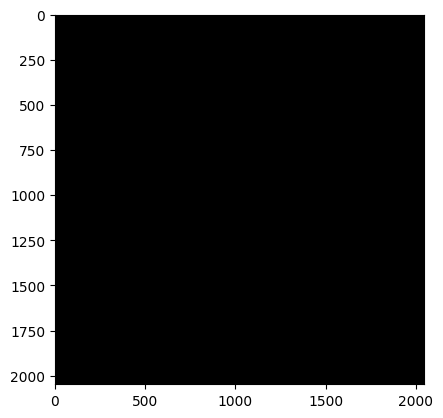

In [20]:
render_novel = cv2.cvtColor(render_novel, cv2.COLOR_BGR2RGB)
plt.imshow(render_novel)

In [21]:
print(data_i['lmain']['depth'].shape)
valid_inds = (data_i['lmain']['mask'][0][0].detach().cpu().numpy() > 0)      
valid_inds

torch.Size([1, 1, 1024, 1024])


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [22]:
depth_vals = data_i['lmain']['depth'][0][0].detach().cpu().numpy()[valid_inds].copy() #convert to cm
x, y = np.meshgrid(np.arange(1024), np.arange(1024))
x = x[valid_inds]
y = y[valid_inds] # flip y to match the image coordinate system
z = depth_vals

In [23]:
depth_vals

array([-0.4583855 , -0.45286533, -0.42947537, ..., -0.69158286,
       -0.69498634, -0.6892484 ], dtype=float32)

In [24]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array([x, y, z * 10]).T)
o3d.visualization.draw_geometries([pcd])

"""pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Xs[:,:3])
pcd.colors = o3d.utility.Vector3dVector(colors/255.0)
o3d.io.write_point_cloud(f"frame_009_flo.ply", pcd)
#print(pcd)
o3d.visualization.draw_geometries([pcd])"""

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


'pcd = o3d.geometry.PointCloud()\npcd.points = o3d.utility.Vector3dVector(Xs[:,:3])\npcd.colors = o3d.utility.Vector3dVector(colors/255.0)\no3d.io.write_point_cloud(f"frame_009_flo.ply", pcd)\n#print(pcd)\no3d.visualization.draw_geometries([pcd])'

In [25]:
data_i['lmain']['xyz'][0]

tensor([[-1.4555e+08, -7.9279e+07,  3.8880e+07],
        [-1.4543e+08, -7.9264e+07,  3.8943e+07],
        [-1.4530e+08, -7.9250e+07,  3.9005e+07],
        ...,
        [-3.1173e+07,  7.7785e+07,  9.5811e+07],
        [-3.1049e+07,  7.7799e+07,  9.5874e+07],
        [-3.0925e+07,  7.7813e+07,  9.5937e+07]], device='cuda:0')

In [26]:
from torch.cuda.amp import autocast as autocast
bs = data['lmain']['img'].shape[0]

image = torch.cat([data['lmain']['img'], data['rmain']['img']], dim=0)


with autocast(enabled=render.model.cfg.raft.mixed_precision):
    img_feat = render.model.img_encoder(image)

"""lmsk = item['lmain']['img'].permute(1,2,0).cpu().numpy() > 0
lmsk"""
item['lmain']['img'].shape

torch.Size([1, 3, 1024, 1024])

In [27]:
flow_up = render.model.raft_stereo(img_feat[2], iters=render.model.val_iters, test_mode=True)

In [28]:
item['lmain']['flow_pred'] = flow_up[0]
item['rmain']['flow_pred'] = flow_up[1]


In [29]:
item['lmain']['mask'].shape

torch.Size([1, 3, 1024, 1024])

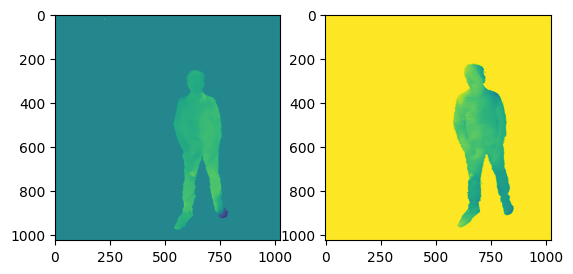

In [30]:
plt.subplot(1,2,1)
plt.imshow(item['lmain']['mask'][0][0].detach().cpu().numpy() * flow_up[0][0].detach().cpu().numpy().squeeze())
plt.subplot(1,2,2)
plt.imshow(item['rmain']['mask'][0][0].detach().cpu().numpy() * flow_up[1][0].detach().cpu().numpy().squeeze())

In [123]:
lmain = cv2.cvtColor(cv2.imread('data/recti_karate/rectified1.png'), cv2.COLOR_BGR2RGB)
rmain = cv2.cvtColor(cv2.imread('data/recti_karate/rectified2.png'), cv2.COLOR_BGR2RGB)
lmaintensor = torch.from_numpy(lmain).permute(2,0,1).unsqueeze(0).float().cuda()
rmaintensor = torch.from_numpy(rmain).permute(2,0,1).unsqueeze(0).float().cuda()

In [124]:
from torch.cuda.amp import autocast as autocast
bs = data['lmain']['img'].shape[0]

image = torch.cat([lmaintensor, lmaintensor], dim=0)


with autocast(enabled=render.model.cfg.raft.mixed_precision):
    img_feat = render.model.img_encoder(image)

"""lmsk = item['lmain']['img'].permute(1,2,0).cpu().numpy() > 0
lmsk"""

"lmsk = item['lmain']['img'].permute(1,2,0).cpu().numpy() > 0\nlmsk"

In [125]:
flow_up = render.model.raft_stereo(img_feat[2], iters=render.model.val_iters, test_mode=True)

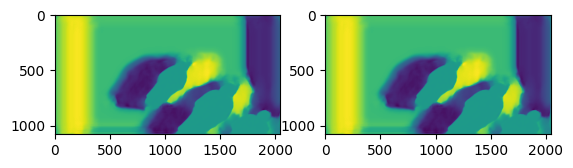

In [126]:
plt.subplot(1,2,1)
plt.imshow(flow_up[0][0].detach().cpu().numpy().squeeze())
plt.subplot(1,2,2)
plt.imshow(flow_up[1][0].detach().cpu().numpy().squeeze())

In [47]:
disparity_l = flow_up[0] /10
disparity_r = flow_up[1] /10
"""depth = -disparity / data['Tf_x'][:, None, None, None]
depth *= data['mask'][:, :1, :, :]"""

"depth = -disparity / data['Tf_x'][:, None, None, None]\ndepth *= data['mask'][:, :1, :, :]"

In [48]:
disparity_l.shape

torch.Size([1, 1, 1080, 2048])

In [49]:
lr_depth = torch.concat([disparity_l, disparity_r], dim=0)
rot_maps, scale_maps, opacity_maps = render.model.gs_parm_regresser(image, lr_depth, img_feat)

In [61]:
depth_map.shape

torch.Size([1, 3, 1080, 2048])

2024-12-23 15:49:55,193 WARNING  [image.py:720] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


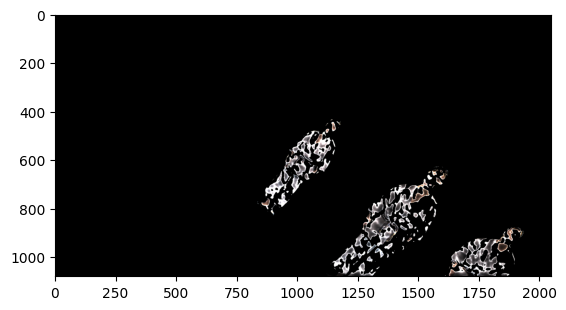

In [127]:
depth_map = 0.01 / (disparity_l + 1e-6)
depth_map = (lmaintensor > 0) * depth_map

plt.imshow((depth_map[0].permute(1,2,0).detach().cpu().numpy()).squeeze() * lmain/100)


In [117]:
import open3d as o3d

valid_inds = (lmain[:,:,0] > 0)    
depth_map = depth_map[0].permute(1,2,0).detach().cpu().numpy().squeeze()
depth_vals = depth_map[valid_inds].copy() #convert to cm  
x, y = np.meshgrid(np.arange(2048), np.arange(1080))
x = x[valid_inds]
y = y[valid_inds] # flip y to match the image coordinate system
z = depth_vals[:,0]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array([x, y, z]).T)
o3d.visualization.draw_geometries([pcd])

"""pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Xs[:,:3])
pcd.colors = o3d.utility.Vector3dVector(colors/255.0)
o3d.io.write_point_cloud(f"frame_009_flo.ply", pcd)
#print(pcd)
o3d.visualization.draw_geometries([pcd])"""

'pcd = o3d.geometry.PointCloud()\npcd.points = o3d.utility.Vector3dVector(Xs[:,:3])\npcd.colors = o3d.utility.Vector3dVector(colors/255.0)\no3d.io.write_point_cloud(f"frame_009_flo.ply", pcd)\n#print(pcd)\no3d.visualization.draw_geometries([pcd])'

In [115]:
depth_vals.shape

(182464, 3)

## Now try getting rectification on karate data

In [50]:
cfg.defrost()
cfg.batch_size = 1
cfg.dataset.test_data_root = 'data/karate'
cfg.dataset.use_processed_data = False
cfg.restore_ckpt = arg.ckpt_path
cfg.test_out_path = './interp_out/karate'
cfg.freeze()

In [51]:
render = StereoHumanRender(cfg, phase='test')

2024-12-04 10:06:31,394 INFO     [1735310003.py:42] Loading checkpoint from pretrained/GPS-GS_stage2_final.pth ...
2024-12-04 10:06:31,673 INFO     [1735310003.py:45] Parameter loading done


In [52]:
item = render.dataset.get_test_item(0, source_id=[9,17]) #containing images (-1,1), masks and cam parameters

In [54]:
sample_id = 0 % len(render.dataset.sample_list)
print(sample_id)
sample_name = render.dataset.sample_list[sample_id]
view0_data = render.dataset.load_single_view(sample_name, 9, hr_img=False, require_mask=True, require_pts=False)

0


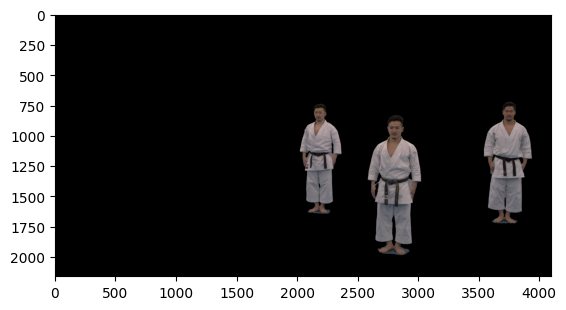

In [55]:
import matplotlib.pyplot as plt
plt.imshow(view0_data[0])

2024-12-04 10:06:44,205 WARNING  [image.py:720] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-12-04 10:06:44,286 WARNING  [image.py:720] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


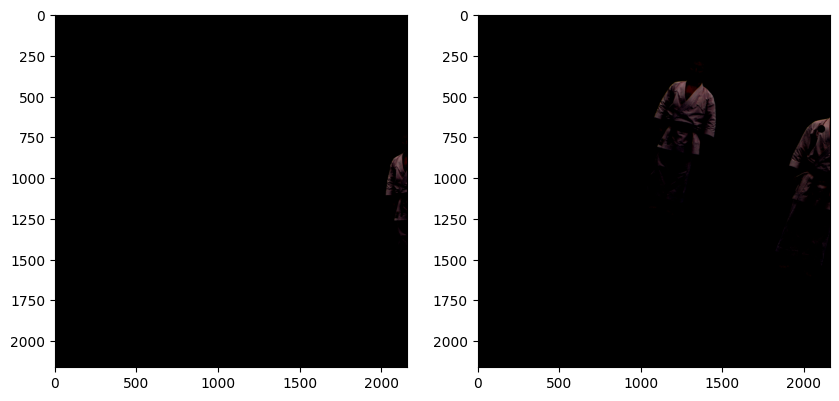

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(item['lmain']['img'].permute(1,2,0).cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(item['rmain']['img'].permute(1,2,0).cpu().numpy())

In [57]:
item['lmain']['extr'], item['rmain']['extr']

(tensor([[ 9.8424e-01, -1.7667e-01,  7.9927e-03,  1.2002e+03],
         [ 1.7482e-01,  9.7876e-01,  1.0706e-01,  7.4463e+03],
         [ 2.6737e-02,  1.0397e-01, -9.9422e-01, -5.1270e+02]]),
 tensor([[ 9.8424e-01, -1.7667e-01,  7.9927e-03,  1.2002e+03],
         [ 1.7482e-01,  9.7876e-01,  1.0706e-01, -7.2551e+03],
         [ 2.6737e-02,  1.0397e-01, -9.9422e-01, -5.1270e+02]]))

# Conclusion: couldn't get the rectification to work. Need to rework on rectification

In [58]:
import csv
from collections import namedtuple
def get_all_rows_from_csv_as_numpy_float(csv_file, num_cols):
    with open(csv_file, 'r') as f:
        reader = csv.reader(f)
        rows = [row for row in reader]
    rows = np.array(rows)[:,:num_cols].astype(np.float32)
    return rows

def get_cam_params_from_csv(input_dir):
    cam_params = []
    extrinsicts_file = os.path.join(input_dir, "camera_extrinsic.csv")
    instrinsics_file = os.path.join(input_dir, "camera_intrinsic.csv")
    distortion_file = os.path.join(input_dir, "camera_distortion.csv")
    #info_list_file = os.path.join(input_dir, "info_list.csv")

    extrinsics = get_all_rows_from_csv_as_numpy_float(extrinsicts_file, 9)
    instrinsics = get_all_rows_from_csv_as_numpy_float(instrinsics_file, 5)
    distortion = get_all_rows_from_csv_as_numpy_float(distortion_file, 8)
    #caminfo = get_all_rows_from_csv_as_numpy_float(info_list_file, 3)
    for i in range(len(extrinsics)):
        camParams = namedtuple('camParams', 'inParam, exParam, diParam')
        cam_params.append(camParams(inParam=instrinsics[i], exParam=extrinsics[i], diParam=distortion[i]))
    return cam_params

cam_params = get_cam_params_from_csv("C:/Users/CanonUser/OneDrive - CanonUSA365/Documents/GitHub/pcd_generation/data/cinc/shoto_11270210/camParam")

In [59]:
def reorder_cam_params(cam_params, cam_param_dir):
    csv_file = os.path.join(cam_param_dir, "info_list.csv")
    with open(csv_file, 'r') as f:
        reader = csv.reader(f)
        rows = [row for row in reader]
    new_cam_params = [None] * len(cam_params)
    for i in range(len(rows)):
        index = int(rows[i][1]) - 1
        new_cam_params[index] = cam_params[i]
    return new_cam_params

cam_params = reorder_cam_params(cam_params, "C:/Users/CanonUser/OneDrive - CanonUSA365/Documents/GitHub/pcd_generation/data/cinc/shoto_11270210/camParam")

In [60]:
cam_params[17]

camParams(inParam=array([4975.3335,    0.    , 2060.0002, 4975.3335, 1092.253 ],
      dtype=float32), exParam=array([-9.3612976e+02, -7.2679468e+03,  8.0001636e+02,  1.1372880e-01,
        9.9076867e-01, -7.3778123e-02, -6.8707480e-03, -7.3473826e-02,
       -9.9727350e-01], dtype=float32), diParam=array([0.0278382 , 0.5125978 , 0.        , 0.        , 0.06211805,
       0.        , 0.        , 0.        ], dtype=float32))

In [ ]:
def calcExtrinsicVecs(exParam, world_2_opencv=None):
    t = exParam[:3].copy()  # Translation vector
    d = exParam[3:6].copy()  # Direction vector
    a = exParam[6:].copy()  # Axis vector, axis vector is the y direction of the image plane pointing down
    
    t[1], t[2] = t[2], t[1]
    d[1], d[2] = d[2], d[1]
    a[1], a[2] = a[2], a[1]

    # Normalize the axis vector to get the y-axis (ry)
    ry = np.reshape(a / np.linalg.norm(a), (3)) # y axis is the direction the camera is facing
    print(ry)
    # Normalize the direction vector to get the z-axis (rz)
    rz = np.reshape(d / np.linalg.norm(d), (3))
    
    # Compute the cross product of ry and rz to get the x-axis (rx), x axis is the rightward direction of the image plane
    rx = np.reshape(np.cross(ry, rz), (3))
    rx = rx / np.linalg.norm(rx)  # Normalize rx

    
    # Construct the rotation matrix R. commented out .T because without it, the rotation matrix ia assumed to be from a calibration procedure
    R = np.array([rx, ry, rz]).T # .T is removed 

    # Create a named tuple to store R and t
    exVecs = namedtuple("exVecs", "R, t")
    #t[1], t[2] = -t[2], t[1]

    if world_2_opencv is not None:
        R = world_2_opencv @ R @ world_2_opencv.T
        t = world_2_opencv @ t

    return exVecs(R=R, t=-t)

In [316]:
# test for angles
# Given rotation matrix
def get_angles_from_R(R):
    yaw = np.arctan2(R[1, 0], R[0, 0])  # psi
    pitch = np.arcsin(-R[2, 0])         # theta
    roll = np.arctan2(R[2, 1], R[2, 2]) # phi

    # Convert from radians to degrees for better interpretation
    yaw_deg = np.degrees(yaw)
    pitch_deg = np.degrees(pitch)
    roll_deg = np.degrees(roll)

    return yaw_deg, pitch_deg, roll_deg

In [317]:
world_2_opencv = np.array([[1, 0,  0], 
                           [0, 0,  1], 
                           [0, -1, 0]]) 
world_2_opencv

array([[ 1,  0,  0],
       [ 0,  0,  1],
       [ 0, -1,  0]])

In [318]:
R1, t1 = calcExtrinsicVecs(cam_params[17][1])
R1 = R1.astype(np.float64)
t1 = t1.astype(np.float64)/1
R2, t2 = calcExtrinsicVecs(cam_params[9][1])
R2 = R2.astype(np.float64)
t2 = t2.astype(np.float64)/1
R1, t1, R2, t2


[-0.00687075 -0.9972735  -0.07347383]
[ 0.02721183 -0.9949829  -0.09627368]


(array([[-0.99348807, -0.00154877,  0.11392563],
        [-0.00687075, -0.9972735 , -0.07347383],
        [ 0.1137288 , -0.07377812,  0.99076867]]),
 array([ 936.12976074, -800.01635742, 7267.94677734]),
 array([[-0.96841955, -0.00236181, -0.24931528],
        [ 0.02721183, -0.9949829 , -0.09627368],
        [-0.24783704, -0.10001763,  0.96362507]]),
 array([ -686.60662842, -2006.49694824,  7256.28955078]))

In [319]:
# test for angles
# Given rotation matrix
def get_angles_from_R(R):
    yaw = np.arctan2(R[1, 0], R[0, 0])  # psi
    pitch = np.arcsin(-R[2, 0])         # theta
    roll = np.arctan2(R[2, 1], R[2, 2]) # phi

    # Convert from radians to degrees for better interpretation
    yaw_deg = np.degrees(yaw)
    pitch_deg = np.degrees(pitch)
    roll_deg = np.degrees(roll)

    return yaw_deg, pitch_deg, roll_deg
get_angles_from_R(R2)

(178.39045726871785, 14.349556001359401, -5.92568796149874)

In [320]:
f = cam_params[14][0][0].copy()
cx, cy = cam_params[14][0][2].copy(), cam_params[14][0][4].copy()
K1 = np.array([[f, 0, cx],
               [0, f, cy],
               [0, 0,  1]])  
f = cam_params[22][0][0].copy()
cx, cy = cam_params[22][0][2].copy(), cam_params[22][0][4].copy()
K2 = np.array([[f, 0, cx],
               [0, f, cy],
               [0, 0,  1]])
K1 = K1.astype(np.float64)
K2= K2.astype(np.float64)
K1, K2

(array([[4.70212646e+03, 0.00000000e+00, 2.05676416e+03],
        [0.00000000e+00, 4.70212646e+03, 1.09076086e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[6.04039014e+03, 0.00000000e+00, 2.07830371e+03],
        [0.00000000e+00, 6.04039014e+03, 1.09306519e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]))

In [321]:
dist1 = np.array([0, 0, cam_params[1].diParam[2], cam_params[1].diParam[3], 0])
dist2 = np.array([0, 0, cam_params[7].diParam[2], cam_params[7].diParam[3], 0])
dist1 = dist1.astype(np.float64)
dist2 = dist2.astype(np.float64)

In [322]:
R = R2 @ R1.T
t = t2 - R @ t1
R1_rect, R2_rect, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    K1, dist1, K2, dist2, (view0_data[0].shape[1], view0_data[0].shape[0]), R, t.reshape(3,1))
t,t1,t2

(array([ 1055.66633519, -1035.78748337,   159.69707428]),
 array([ 936.12976074, -800.01635742, 7267.94677734]),
 array([ -686.60662842, -2006.49694824,  7256.28955078]))

In [323]:
R1_rect@R1,R2_rect@R2, P1, P2

(array([[-0.73281302,  0.68039957, -0.00644455],
        [-0.67525369, -0.72837159, -0.11622096],
        [-0.08377072, -0.08081653,  0.99320248]]),
 array([[-0.73281306,  0.68039958, -0.00644455],
        [-0.67525373, -0.72837159, -0.11622097],
        [-0.08377071, -0.08081653,  0.99320248]]),
 array([[5.37125830e+03, 0.00000000e+00, 2.18482694e+03, 0.00000000e+00],
        [0.00000000e+00, 5.37125830e+03, 1.16621814e+03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 array([[5.37125830e+03, 0.00000000e+00, 2.18482694e+03, 7.98998870e+06],
        [0.00000000e+00, 5.37125830e+03, 1.16621814e+03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]))

In [324]:
get_angles_from_R(R1), get_angles_from_R(R2), get_angles_from_R(R1_rect@R1), get_angles_from_R(R2_rect@R2)

((-179.60376113442186, -6.530309554460249, -4.258701019664144),
 (178.39045726871785, 14.349556001359401, -5.92568796149874),
 (-137.34084882459481, 4.8053399639797725, -4.651888301234461),
 (-137.34084884236077, 4.805339511236973, -4.651888184675206))

In [325]:
image_size = (view0_data[0].shape[1], view0_data[0].shape[0])
map1x, map1y = cv2.initUndistortRectifyMap(K1, dist1, R1, P1, image_size, cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(K2, dist2, R2, P2, image_size, cv2.CV_32FC1)

In [326]:
sample_name = render.dataset.sample_list[sample_id]
print(sample_name)
view1_data = render.dataset.load_single_view(sample_name, 17, hr_img=False, require_mask=True, require_pts=False)

00001


In [327]:
view0_data[0].shape

(2160, 4096, 3)

In [332]:
rectified_img1 = cv2.remap(view0_data[0], map1x, view0_data[0].shape[0]-map1y, cv2.INTER_LINEAR)
rectified_img2 = cv2.remap(view1_data[0], map2x, view0_data[0].shape[0]-map2y, cv2.INTER_LINEAR)

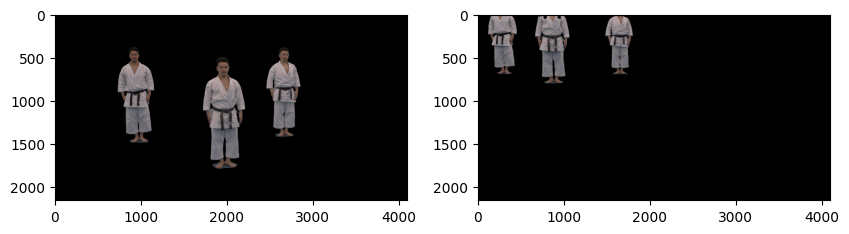

In [333]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(rectified_img1)
plt.subplot(1,2,2)
plt.imshow(rectified_img2)

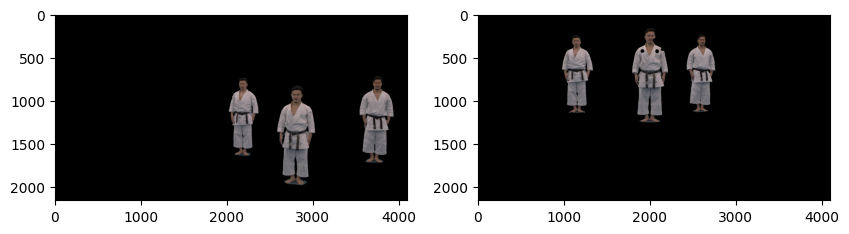

In [277]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(view0_data[0])
plt.subplot(1,2,2)
plt.imshow(view1_data[0])

# Conclusion: opencv based functions don't work. Now rewrite those functions 

In [336]:
import numpy as np
from scipy.ndimage import map_coordinates

# Step 1: Compute the new coordinate system
def compute_rectification_transform(R1, t1, t2):
    # Baseline
    t = t2 - t1
    x_axis = t / np.linalg.norm(t)

    # z-axis (adjusted to be orthogonal to x-axis)  z axis is the direction the camera is facing
    z_axis = R1[:, 1].copy()
    z_axis -= np.dot(z_axis, x_axis) * x_axis
    z_axis /= np.linalg.norm(z_axis)

    # y-axis
    y_axis = np.cross(z_axis, x_axis)
    y_axis /= np.linalg.norm(y_axis)

    # Rectification rotation matrix
    # organized in rows so that R_rect @ P_world = P_rect, that is R_rect transforms a point in world coordinates to rectified coordinates
    R_rect = np.array([x_axis, z_axis, y_axis]) #want to arrange so that x, y, z are consistent with karate world coordinates
    return R_rect

In [337]:
# Step 2: Compute the rectified rotation matrices
def rectify_cameras(K1, R1, t1, K2, R2, t2):
    R_rect = compute_rectification_transform(R1, t1, R2, t2)
    R1_rect = R_rect
    R2_rect = R_rect
    return R1_rect, R2_rect

# Step 3: Create rectified projection matrices
def compute_projection_matrices(K1, K2, R1_rect, R2_rect, t1, t2):
    P1_rect = K1 @ np.hstack((R1_rect, np.zeros((3, 1))))
    P2_rect = K2 @ np.hstack((R2_rect, R2_rect @ (t2 - t1).reshape(-1, 1)))
    return P1_rect, P2_rect

In [338]:
def calcExtrinsicVecs(exParam, world_2_opencv=None):
    t = exParam[:3].copy()  # Translation vector
    d = exParam[3:6].copy()  # Direction vector
    a = exParam[6:].copy()  # Axis vector, axis vector is the y direction of the image plane pointing down

    # Normalize the axis vector to get the y-axis (ry)
    ry = np.reshape(a / np.linalg.norm(a), (3)) # y axis is the direction the camera is facing
    # Normalize the direction vector to get the z-axis (rz)
    rz = np.reshape(d / np.linalg.norm(d), (3))
    
    # Compute the cross product of ry and rz to get the x-axis (rx), x axis is the rightward direction of the image plane
    rx = np.reshape(np.cross(ry, rz), (3))
    rx = rx / np.linalg.norm(rx)  # Normalize rx

    
    # Construct the rotation matrix R. commented out .T because without it, the rotation matrix ia assumed to be from a calibration procedure
    R = np.array([rx, rz, ry]).T # .T is removed 

    # Create a named tuple to store R and t
    exVecs = namedtuple("exVecs", "R, t")
    #t[1], t[2] = -t[2], t[1]

    if world_2_opencv is not None:
        R = world_2_opencv @ R @ world_2_opencv.T
        t = world_2_opencv @ t

    return exVecs(R=R, t=t)

In [343]:
R1, t1 = calcExtrinsicVecs(cam_params[17][1])
R1 = R1.astype(np.float64)
t1 = t1.astype(np.float64)/1
R2, t2 = calcExtrinsicVecs(cam_params[9][1])
R2 = R2.astype(np.float64)
t2 = t2.astype(np.float64)/1
print(R1, t1, t2)
print(R2)
print(compute_rectification_transform(R1, t1, t2))
print(get_angles_from_R(R1), get_angles_from_R(compute_rectification_transform(R1, t1, t2).T))


[[ 0.99348807  0.1137288  -0.00687075]
 [-0.11392563  0.99076867 -0.07347383]
 [ 0.00154877 -0.07377812 -0.9972735 ]] [ -936.12976074 -7267.94677734   800.01635742] [  686.60662842 -7256.28955078  2006.49694824]
[[ 0.96841955 -0.24783704  0.02721183]
 [ 0.24931528  0.96362507 -0.09627368]
 [ 0.00236181 -0.10001763 -0.9949829 ]]
[[ 0.80248915  0.00576483  0.59663886]
 [ 0.07133     0.99185524 -0.10552351]
 [ 0.5923877  -0.12723972 -0.79554187]]
(-6.541668709521109, -0.08873790653335818, -175.76897565512658) (0.4115877344223138, -36.62955097944032, -172.44419070530284)


In [344]:
f = cam_params[17][0][0].copy()
cx, cy = cam_params[17][0][2].copy(), cam_params[17][0][4].copy()
K1 = np.array([[f, 0, cx],
               [0, f, cy],
               [0, 0,  1]])  
f = cam_params[9][0][0].copy()
cx, cy = cam_params[9][0][2].copy(), cam_params[9][0][4].copy()
K2 = np.array([[f, 0, cx],
               [0, f, cy],
               [0, 0,  1]])
K1 = K1.astype(np.float64)
K2= K2.astype(np.float64)
K1, K2

(array([[4.97533350e+03, 0.00000000e+00, 2.06000024e+03],
        [0.00000000e+00, 4.97533350e+03, 1.09225305e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[5.25084619e+03, 0.00000000e+00, 2.07697046e+03],
        [0.00000000e+00, 5.25084619e+03, 1.10072119e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]))

In [345]:
P1, P2 = compute_projection_matrices(K1, K2, R1_rect, R2_rect, t1, t2)

In [346]:
P1, P2

(array([[ 4.01814426e+03, -3.33169172e+03,  1.32359034e+03,
          0.00000000e+00],
        [ 3.49210066e+03,  3.68853284e+03,  3.83299618e+02,
          0.00000000e+00],
        [ 1.96501587e-01,  8.19736369e-03,  9.80469239e-01,
          0.00000000e+00]]),
 array([[ 3.38095939e+03, -3.69252056e+03,  2.61143591e+03,
          8.59400802e+06],
        [ 3.41180455e+03,  3.74839768e+03,  1.75843039e+03,
          7.70166745e+06],
        [-1.66304470e-01, -1.74877492e-02,  9.85919369e-01,
          9.19420409e+02]]))

In [254]:
def remap_image(image, map_x, map_y):
    coords = np.vstack((map_y.ravel(), map_x.ravel()))
    remapped = map_coordinates(image, coords, order=1).reshape(image.shape)
    return remapped

In [38]:
# read camera parameters specially for the karate dataset
import glob
import json

basedir = "C:/Users/CanonUser/OneDrive - CanonUSA365/Documents/GitHub/pcd_generation/data/cinc/"
inputdir = basedir + "shoto_11270210/"
imgdir = [inputdir + s for s in ["c014/", "c009/","c022/", "c001/", "c007/"]] 


In [39]:
imgdir

['C:/Users/CanonUser/OneDrive - CanonUSA365/Documents/GitHub/pcd_generation/data/cinc/shoto_11270210/c014/',
 'C:/Users/CanonUser/OneDrive - CanonUSA365/Documents/GitHub/pcd_generation/data/cinc/shoto_11270210/c009/',
 'C:/Users/CanonUser/OneDrive - CanonUSA365/Documents/GitHub/pcd_generation/data/cinc/shoto_11270210/c022/',
 'C:/Users/CanonUser/OneDrive - CanonUSA365/Documents/GitHub/pcd_generation/data/cinc/shoto_11270210/c001/',
 'C:/Users/CanonUser/OneDrive - CanonUSA365/Documents/GitHub/pcd_generation/data/cinc/shoto_11270210/c007/']

In [ ]:
!python test_view_interp.py --test_data_root real_data --ckpt_path pretrained/GPS-GS_stage2_final.pth --novel_view_num 5
